Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100) # let dataframes expand out all columns

Define a couple functions to create dummy variables for the subcategories. Shouldn't need to worry about these too much, they just put 1's under the columns of the subcategories the project falls under and 0's in the columns the project is not classified as.

In [2]:
def splitSubcat(df):
    df = df.copy()
    ext = [np.nan, np.nan]
    results = []
    for row in df['subcat_tree'].iteritems():
        if type(row[1]) is str:
            if ',' in row[1]:
                ext = list(map(lambda x: x.strip(), row[1].split(',')))
            else:
                ext[0] = row[1].strip()
                ext[1] = np.nan

            results.append([ext[0], ext[1]])
        else:
            results.append([np.nan, np.nan])
        
    results = pd.DataFrame(results, columns=['subcat_first', 'subcat_second'], index=df.index)
    print('Finished Splitting...')
    return df.merge(results, right_index=True, left_index=True).drop('subcat_tree', axis=1)

def sumSubcats(df, columns):
    df = df.copy()
    df2 = pd.get_dummies(df, prefix='s', columns=columns)
    cols, col_counts = np.unique(df2.columns.values, return_counts=True)
    for i, col in enumerate(cols):
        if col_counts[i] == 1:
            df[col] = df2[col]
        elif col_counts[i] > 1:
            df[col] = df2[col].sum(axis=1)
    return df

Import all the datasets.

In [3]:
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

Take a random sample of $n=10000$ from the projects dataset. Merge this with schools, aligning `school_id`. Get rid of a few columns we don't care about (for the time being). Then create the dummy variables using the functions above.

In [4]:
sample = projects_notext_dat.sample(10000)
merge = sample.merge(teachers_dat, on='teacher_id').merge(schools_dat, on='school_id')
end = merge.drop(['proj_post_seq', 'proj_type', 'funded', 'posted', 'expire', 'first_project_posted'], axis=1)

In [5]:
cat_break = sumSubcats(splitSubcat(end), ['subcat_first', 'subcat_second'])

Finished Splitting...


Basically, clean the dataset so it's only 1's and 0's which we can compare. More info inline.

In [6]:
num_mat = cat_break.select_dtypes(np.number) # use only the numerical columns

num_mat = num_mat[num_mat['prefix'] > 0] # limit teacher prefix to only Mrs. and Mr.
num_mat['prefix'] = num_mat['prefix'] - 1 # reduce teacher prefix to only 1's and 0's

# we'll create four sets of dummy variables
metros = []
grades = []
costs = []
lunches = []
locations = []

num_mat.dropna(inplace=True) # get rid of rows that have one or more null values

for i, row in num_mat.iterrows():
    
    # iterate over each row in the subset thus far, we'll create dummy variables for each select feature
    
    # expand metropolitan type
    res = [0, 0, 0, 0, 0]
    if row['metro_type'] == 1:
        res[0] = 1 # rural
    elif row['metro_type'] == 2:
        res[1] = 1 # suburban
    elif row['metro_type'] == 3:
        res[2] = 1 # urban
    elif row['metro_type'] == 4:
        res[3] = 1 # town
    elif row['metro_type'] == 0:
        res[4] = 1 # ambiguous
        
    metros.append(np.array(res))
    
    # expand grade level
    res = [0, 0, 0, 0]
    if row['grade_level'] == 2:
        res[0] = 1
    elif row['grade_level'] == 3:
        res[1] = 1
    elif row['grade_level'] == 6:
        res[2] = 1
    elif row['grade_level'] == 9:
        res[3] = 1
        
    grades.append(np.array(res))
    
    # expand and bin the cost of the project
    res = [0, 0, 0, 0, 0, 0]
    if row['cost'] < 250:
        res[0] = 1
    elif row['cost'] < 500:
        res[1] = 1
    elif row['cost'] < 750:
        res[2] = 1
    elif row['cost'] < 1000:
        res[3] = 1
    elif row['cost'] < 1250:
        res[4] = 1
    elif row['cost'] >= 1250:
        res[5] = 1
        
    costs.append(np.array(res))
    
    # expand and bin the portion of students getting free lunch
    res = [0, 0, 0, 0]
    if row['free_lunch'] < 25:
        res[0] = 1
    elif row['free_lunch'] < 50:
        res[1] = 1
    elif row['free_lunch'] < 75:
        res[2] = 1
    elif row['free_lunch'] <= 100:
        res[3] = 1
        
    lunches.append(np.array(res))
    
    res = [0, 0, 0, 0, 0]
    if row['school_zip'] < 30000: #'East'
        res[0] = 1
    elif row['school_zip'] < 50000: #'Southeast'
        res[1] = 1
    elif row['school_zip'] < 80000: #'Mideast'
        res[2] = 1
    elif row['school_zip'] < 90000: #'Midwest'
        res[3] = 1
    else: #'West'
        res[4] = 1
        
    locations.append(np.array(res))
        
# merge all these dummy variables into the original matrix and get rid of the original columns
metros = pd.DataFrame(metros, columns=['rural', 'suburban', 'urban', 'town', 'ambiguous_metro'], index=num_mat.index)
grades = pd.DataFrame(grades, columns=['grade2', 'grade3', 'grade6', 'grade9'], index=num_mat.index)
costs = pd.DataFrame(costs, columns=['cost250', 'cost500', 'cost750', 'cost1000', 'cost1250', 'cost1250g'], index=num_mat.index)
lunches = pd.DataFrame(lunches, columns=['lunch25', 'lunch50', 'lunch75', 'lunch100'], index=num_mat.index)
locations = pd.DataFrame(locations, columns=['east', 'southeast', 'mideast', 'midwest', 'west'], index=num_mat.index)

num_mat = num_mat.merge(metros, left_index=True, right_index=True).drop('metro_type', axis=1)
num_mat = num_mat.merge(grades, left_index=True, right_index=True).drop('grade_level', axis=1)
num_mat = num_mat.merge(costs, left_index=True, right_index=True).drop('cost', axis=1)
num_mat = num_mat.merge(lunches, left_index=True, right_index=True).drop('free_lunch', axis=1)
num_mat = num_mat.merge(locations, left_index=True, right_index=True).drop('school_zip', axis=1)

print(num_mat.shape) # size of the matrix
num_mat.sample(5) # randoly sample 5

(6200, 56)


,status,prefix,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth,rural,suburban,urban,town,ambiguous_metro,grade2,grade3,grade6,grade9,cost250,cost500,cost750,cost1000,cost1250,cost1250g,lunch25,lunch50,lunch75,lunch100,east,southeast,mideast,midwest,west
3384,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
6904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1386,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3681,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2617,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0


Compute a distance matrix. Every entry is the distance from the ith to the jth element. Subset the matrix to include only the ij-th entry, not the ji-th.

https://link.springer.com/article/10.1007/BF00377169

https://stats.stackexchange.com/questions/61705/similarity-coefficients-for-binary-data-why-choose-jaccard-over-russell-and-rao

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

https://stats.stackexchange.com/questions/55798/what-is-the-optimal-distance-function-for-individuals-when-attributes-are-nomina/55802#55802

https://en.wikipedia.org/wiki/Jaccard_index

http://www.iiisci.org/journal/CV$/sci/pdfs/GS315JG.pdf

https://www.umass.edu/landeco/teaching/multivariate/readings/McCune.and.Grace.2002.chapter6.pdf

In [7]:
from scipy.spatial.distance import cdist

Y = cdist(num_mat, num_mat, 'jaccard')

print('Similarities cast...')

low = np.tril_indices(Y.shape[0], -1) # Remove the bottom triangular
Y[low[0], low[1]] = np.nan

Similarities cast...


Sample the first 100 projects and visualize their similarity. 0 is completely similar, 1 is completely dissimilar.

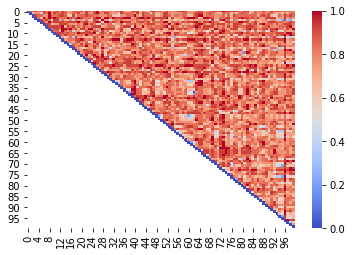

In [8]:
sns.heatmap(Y[:100, :100], cmap='coolwarm')

Extract the most similar other project for $j\geq i$.

In [9]:
# variable equal to the 1st column of Y, excluding the last row, sorted within row
top_similarities = Y[:-1].argsort(axis=1)[:, 1]

In [10]:
ds = []
indices = []

for i, j in enumerate(top_similarities):
    ds.append(Y[i, j])
    
    ixs = num_mat.iloc[[i, j], :].index
    indices.append(ixs)
    
    if i < 2:
        print('distance: {}\t({},{})'.format(Y[i, j], i, j))
        print(cat_break.loc[ixs])

distance: 0.3333333333333333	(0,216)
                           project_id                         school_id  \
0    f8cec35e1373b47a76dfb106e9a07f40  4884fee611c9af2b37346471766f9d5f   
377  e616411ce0b0adcb07f917a6fa77cb6b  58e9cf91404b49fa9f848993fe310e76   

                           teacher_id                            cat_tree  \
0    deab41a854738646b3fd4dc50381c453  Applied Learning, Music & The Arts   
377  4e7e711a628bd3cf26d5e4f76e6bf83e                    Music & The Arts   

     grade_level resource_cat     cost  status  prefix  \
0              2     Supplies  1326.38       1       1   
377            2     Supplies   423.74       1       1   

                     school_name  metro_type  free_lunch school_state  \
0    South LaFourche High School           0        67.0    Louisiana   
377             Case High School           0        67.0    Wisconsin   

     school_zip school_city school_county                 school_district  \
0         70345     Cut Off     L

Mean Jaccard similarity coefficient: 0.251


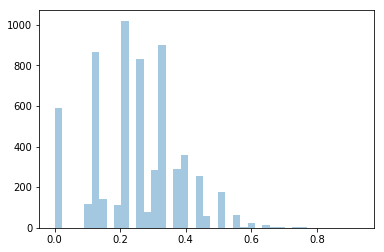

In [11]:
sns.distplot(ds, kde=False)
print('Mean Jaccard similarity coefficient: {:.3f}'.format(np.array(ds).mean()))